In [54]:
import torch, os
import torch.nn as nn
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random
import torch.utils.data as torchdata
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt
import time
# from train_model import train_model
# from test_model import test_model
%matplotlib inline

In [55]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [56]:
filePath = '/local/rcs/ll3504/datasets/256_ObjectCategories/'
namelist = os.listdir(filePath)
nameDic_cal = {}
for name in namelist:
    splits = name.split(".")
    nameDic_cal[int(splits[0])-1] = splits[1]
print(nameDic_cal[1])

american-flag


In [57]:
def get_dataset(path='/database', dataset_name='caltech-256-common'):
    # No holdout testing data. train and test data are the same, but different transformation
    data_transforms = {
        'train': transforms.Compose([
#             transforms.Resize([256, 256]),
#             transforms.RandomCrop(224),
#             transforms.RandomRotation(20),
#             transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
#             transforms.Resize([224, 224]),
#             transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    }

    tr_dataset = datasets.ImageFolder(path + dataset_name + '/', data_transforms['train'])
    te_dataset = datasets.ImageFolder(path + dataset_name + '/', data_transforms['test'])
#     print('{} train set size: {}'.format(dataset_name, len(tr_dataset)))
#     print('{} test set size: {}'.format(dataset_name, len(te_dataset)))

    return tr_dataset, te_dataset

In [58]:
def split_dataset(train_dataset, test_dataset, valid_size=0.2, batch_size=128, train_size = 128):
    '''
    This function splits dataset into train, val, and test sets, and return train, val, test dataloaders.
    Val and Test loaders are the same

    '''
    
    # what does the len function gives?
    num_train = len(train_dataset)
    # print("DEBUGGING: overall training data size =", num_train)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    random.shuffle(indices)
    train_idx, valid_idx = indices[split:split+train_size], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # print("DEBUGGING: the train_ind are:", len(train_idx))


    train_loader = torchdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=48, pin_memory=True, drop_last=True, sampler = train_sampler)
    test_loader = torchdata.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=48, pin_memory=True, drop_last=True, sampler = valid_sampler)
    dataloaders = {'train': train_loader,
                   'val': test_loader,
                   'test': test_loader}
    dataset_sizes ={'train': train_size, #int(np.floor((1-valid_size) * num_train)),
                    'val': int(np.floor(valid_size * num_train)),
                    'test': int(np.floor(valid_size * num_train))}
    return dataloaders, dataset_sizes

In [59]:
imagebase = '/local/rcs/ll3504/datasets/'

In [60]:
corruption = ['zoom_blur', 'speckle_noise', 'spatter',
                       'snow', 'glass_blur', 'motion_blur', 'saturate',
                       'gaussian_blur', 'frost', 'fog', 'brightness', 'contrast',
                       'elastic_transform', 'pixelate', 'jpeg_compression', 'defocus_blur']

# ImageNetC

In [61]:
def get_imagenetc(imagebase, severity=1, batch_size=128, sample_size = 128):
    '''
    Returns:
        ref_dataloaders:          ImageNet original validation data, as a reference
        ref_dataset_sizes:        1000, not the sizes of the real dataset in the ref_loader, probs used downstream
        corrupted_dataloaders:    A list of corrupted dataloaders, each element in a list represetns the data loaders
                                  for one corruption type. Each element contains ['train']['val']['test'] loaders
        corrupted_dataset_sizes:  A list of dictionaries of the sizes of each loaders for each corruption
        corruption:               A list of corruption names, in the same order of the corrupted_dataloaders
    '''
    corruption = ['zoom_blur', 'speckle_noise', 'spatter',
                       'snow', 'glass_blur', 'motion_blur', 'saturate',
                       'gaussian_blur', 'frost', 'fog', 'brightness', 'contrast',
                       'elastic_transform', 'pixelate', 'jpeg_compression', 'defocus_blur']
    corrupted_dataloaders = []
    corrupted_dataset_sizes = []
    
    # this is the imageNet validation data
    imagenet_val = datasets.ImageNet(imagebase+'imagenetc/', split='val', transform=transforms.Compose([
            transforms.Resize([224, 224]),
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
                                   target_transform=None)#, download=False)
    
    # TODO: subsample some size of ImageNet training data as source
        # Doesn't need this step
#     print("DEBUGGING: imagenet_val size is:", len(imagenet_val))
    
    random_indices = random.sample(range(0, len(imagenet_val)), int(len(imagenet_val)*0.02))
#     print("DEBUGGING: random indices are:", len(random_indices))
    imagenet_val_subset = data.Subset(imagenet_val, random_indices)
    val_loader = torch.utils.data.DataLoader(imagenet_val_subset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=48)
    ref_dataloaders = { 'val': val_loader,
                       'test': val_loader}
    ref_dataset_sizes ={'val': int(len(val_loader.dataset)),
                        'test': int(len(val_loader.dataset))}
    
    # for every type of corruption, go to the specified severity folder
    for corr in corruption:
        dataset_name = 'imagenetc/' + corr + '/' + str(severity)
        # Get dataset from folder
        corr_trian_images, corr_test_images = get_dataset(imagebase, dataset_name)
        # get corruption-specific train, val, test loader
        # train: training data, non-overlap with val/test
        # val: non-overlap with train, same as test
        # test: non-overlap with train, same as test
        corr_dataloaders, corr_dataset_sizes = split_dataset(corr_trian_images, corr_test_images, valid_size=0.02, batch_size=batch_size, train_size=sample_size)
        corrupted_dataloaders.append(corr_dataloaders)
        corrupted_dataset_sizes.append(corr_dataset_sizes)
    return ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption

In [9]:
ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption \
= get_imagenetc(imagebase, 5, 32, 32)
# training size = 50000 - 1000 = 49000


In [10]:
# in total 16 corruptions, each have 3 dataloaders ['train']['val']['test']
len(corrupted_dataloaders[15]['val']) # why is this 31??

31

In [11]:
corrupted_dataset_sizes[0]

{'train': 32, 'val': 1000, 'test': 1000}

In [12]:
ref_dataset_sizes['val']

1000

In [13]:
len(ref_dataloaders['val'])

32

# BN Adapt

In [62]:
import torch
from torchvision import models, datasets, transforms

def get_dataset_loader(valdir, batch_size, shuffle):
    val_dataset = datasets.ImageFolder(valdir, transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]))
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=shuffle
    )
    return val_loader

def gce(logits, target, q = 0.8):
    """ Generalized cross entropy.
    
    Reference: https://arxiv.org/abs/1805.07836
    """
    probs = torch.nn.functional.softmax(logits, dim=1)
    probs_with_correct_idx = probs.index_select(-1, target).diag()
    loss = (1. - probs_with_correct_idx**q) / q
    return loss.mean()

def adapt_batchnorm(model):
    model.eval()
    parameters = []
    for module in model.modules():
        if isinstance(module, torch.nn.BatchNorm2d):
            parameters.extend(module.parameters())
            module.train()
    return parameters


# ---

def evaluate(
        data_loader,
        datadir = '/data/imagenetc/gaussian_blur/3',
        num_epochs = 1, # orig = 5
#         batch_size = 128, # orig = 96
        learning_rate = 0.75e-3,
        gce_q = 0.8
    ):

    baseline = models.resnet50(pretrained = True).to(device)
    baseline.eval()
    
    model = models.resnet50(pretrained = True).to(device)
    parameters = adapt_batchnorm(model)

    optimizer = torch.optim.SGD(
        parameters, lr = learning_rate  # orig = model.parameters()
    )
    
#     print("DEBUGGING: checking baseline model")
#     for module in baseline.modules():
#         print("   module is:", module)
#         print("   module.training:", module.training)
    
#     print("DEBUGGING: checking adapted model")
#     for module in model.modules():
#         print("   module is:", module)
#         print("   module.training:", module.training)
    
    b_correct, num_correct, num_samples = 0., 0., 0.
    
    base_acc = []
    adapted_train_acc_overall = []
    

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}')
#         b_correct_epoch, num_correct_epoch, num_samples_epoch = 0., 0., 0.

        for images, targets in data_loader:
            
            # BN adapted model
            logits = model(images.to(device))
            predictions = logits.argmax(dim = 1)
            
            num_correct += (predictions.detach().cpu() == targets).float().sum()
            num_samples += len(targets)
            
            
            # baseline ResNet-50
            b_logits = baseline(images.to(device))
            b_predictions = b_logits.argmax(dim = 1)
            
            b_correct += (b_predictions.detach().cpu() == targets).float().sum()
            
        
        base_acc.append(b_correct / num_samples)
        adapted_train_acc_overall.append(num_correct / num_samples)
        
#         base_acc_epoch.append(b_correct_epoch / num_samples_epoch)
#         adapted_train_acc_per_epoch.append(num_correct_epoch / num_samples_epoch)

        print(f"Baseline Correct: {b_correct:#5.0f}/{num_samples:#5.0f} ({100 * b_correct / num_samples:.2f} %)")
        print(f"Adapted Correct: {num_correct:#5.0f}/{num_samples:#5.0f} ({100 * num_correct / num_samples:.2f} %)")
#         print(f"Baseline Epoch Correct: {b_correct_epoch:#5.0f}/{num_samples_epoch:#5.0f} ({100 * b_correct_epoch / num_samples_epoch:.2f} %)")
#         print(f"Adapted Epoch Correct: {num_correct_epoch:#5.0f}/{num_samples_epoch:#5.0f} ({100 * num_correct_epoch / num_samples_epoch:.2f} %)")
        
        
    return base_acc, adapted_train_acc_overall


## Train on entire dataset

In [63]:
## running the original experiment using the paper hyperparams
acc_record_sev = {}
batch_size = 64
for severity in range(1, 6):
    
    print("Running experiment for severity =", severity)
    
    ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption \
        = get_imagenetc(imagebase, severity, batch_size, 49000)

#     start = time.time()
    base_acc, adapted_train_acc_overall = evaluate(corrupted_dataloaders[3]['train'], num_epochs=5)
#     adapt_time = time.time() - start
    
#     ## evaluate on validation set
#     model.eval()
#     baseline.eval()
#     with torch.no_grad():
#         base_val_correct, crpt_val_correct, crpt_val_samples = 0, 0, 0
#         for images, labels in corrupted_dataloaders[0]['val']:
#             labels = labels.to(device)
#             outputs = model(images.to(device))
#             _, predicted = torch.max(outputs.data, 1)
#             crpt_val_correct += (predicted == labels).sum().item()
#             crpt_val_samples += len(labels)

#             b_outputs = baseline(images.to(device))
#             _, b_predicted = torch.max(b_outputs.data, 1)
#             base_val_correct += (b_predicted == labels).sum().item()


#     print(f"Corrupt Val Adapt Accuracy: {crpt_val_correct:#5.0f}/{crpt_val_samples:#5.0f} ({crpt_val_correct / crpt_val_samples})")
#     print(f"Corrupt Val Base Accuracy: {base_val_correct:#5.0f}/{crpt_val_samples:#5.0f} ({base_val_correct / crpt_val_samples})")

    acc_record_sev[severity] = [base_acc, adapted_train_acc_overall]
    
    print("===================================================================================================")




Running experiment for severity = 1
Epoch 0


Exception ignored in: <function _releaseLock at 0x7f0ca166e5e0>
Traceback (most recent call last):
  File "/home/zw2774/bin/anaconda3/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 43997, 43998, 43999, 44000, 44001, 44002, 44003, 44004, 44005, 44006, 44007, 44008, 44009, 44010, 44011, 44012, 44013, 44014, 44015, 44016) exited unexpectedly

In [64]:
## running the original experiment using the paper hyperparams
acc_record_sev = {}
batch_size = 64
for severity in range(1, 6):
    
    print("Running experiment for severity =", severity)
    
    ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption \
        = get_imagenetc(imagebase, severity, batch_size, 49000)

#     start = time.time()
    base_acc, adapted_train_acc_overall = evaluate(corrupted_dataloaders[3]['train'])
#     adapt_time = time.time() - start
    
#     ## evaluate on validation set
#     model.eval()
#     baseline.eval()
#     with torch.no_grad():
#         base_val_correct, crpt_val_correct, crpt_val_samples = 0, 0, 0
#         for images, labels in corrupted_dataloaders[0]['val']:
#             labels = labels.to(device)
#             outputs = model(images.to(device))
#             _, predicted = torch.max(outputs.data, 1)
#             crpt_val_correct += (predicted == labels).sum().item()
#             crpt_val_samples += len(labels)

#             b_outputs = baseline(images.to(device))
#             _, b_predicted = torch.max(b_outputs.data, 1)
#             base_val_correct += (b_predicted == labels).sum().item()


#     print(f"Corrupt Val Adapt Accuracy: {crpt_val_correct:#5.0f}/{crpt_val_samples:#5.0f} ({crpt_val_correct / crpt_val_samples})")
#     print(f"Corrupt Val Base Accuracy: {base_val_correct:#5.0f}/{crpt_val_samples:#5.0f} ({base_val_correct / crpt_val_samples})")

    acc_record_sev[severity] = [base_acc, adapted_train_acc_overall]
    
    print("===================================================================================================")




Running experiment for severity = 1


KeyboardInterrupt: 

In [17]:
err = 0
for i in range(1, 6):
    err += (1 - acc_record_sev[i][0][0])
err / 5

tensor(0.8532)

## Question: Why does ResNet50.eval() gives higher (10%) error rate than other papers?

In [65]:
baseline = models.resnet50(pretrained=True).to(device)
print("DEBUGGING: checking baseline model")
for module in baseline.modules():
    print("   module is:", module)
    print("   module.training:", module.training)

DEBUGGING: checking baseline model
   module is: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0)

In [ ]:
baseline_acc_train = np.zeros((5, len(corruption)))
for severity in range(1, 6):
    
    print("Running experiment for severity =", severity)
    
    ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption \
        = get_imagenetc(imagebase, severity, batch_size, 49000)

    for cor_idx in range(len(corruption)):
        
        print("------------------------------------------------------")
        print("Corruption =", corruption[cor_idx])
        
        b_correct, num_samples = 0, 0
        for images, targets in corrupted_dataloaders[corruption[cor_idx]]['train']:

            # baseline ResNet-50
            b_logits = baseline(images.to(device))
            b_predictions = b_logits.argmax(dim = 1)

#             print("b_logits:", b_logits.shape)
#             print(b_logits)
#             print("b_predictions:", b_predictions.shape)
#             print(b_predictions)
#             print("targets:", targets.shape)
#             print(targets)
#             print("corrects:")
#             print(b_predictions.detach().cpu() == targets)
            b_correct += (b_predictions.detach().cpu() == targets).float().sum()
#             print(b_correct)
            num_samples += len(targets)


        # base_acc.append(b_correct / num_samples)
        # adapted_train_acc_overall.append(num_correct / num_samples)

        #         base_acc_epoch.append(b_correct_epoch / num_samples_epoch)
        #         adapted_train_acc_per_epoch.append(num_correct_epoch / num_samples_epoch)

        print(f"Baseline Correct: {b_correct:#5.0f}/{num_samples:#5.0f} ({100 * b_correct / num_samples:.2f} %)")
        baseline_acc_train[severity-1][cor_idx] = b_correct / num_samples
        # print(f"Adapted Correct: {num_correct:#5.0f}/{num_samples:#5.0f} ({100 * num_correct / num_samples:.2f} %)")
        
    print("========================================================================")

In [66]:
baseline.eval()
print("DEBUGGING: checking baseline model")
for module in baseline.modules():
    print("   module is:", module)
    print("   module.training:", module.training)

DEBUGGING: checking baseline model
   module is: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0)

In [67]:
baseline_acc_eval = np.zeros((5, len(corruption)))
for severity in range(1, 6):
    
    print("Running experiment for severity =", severity)
    
    ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption \
        = get_imagenetc(imagebase, severity, batch_size, 49000)

    for cor_idx in range(len(corruption)):
        
        print("------------------------------------------------------")
        print("Corruption =", corruption[cor_idx])
        
        b_correct, num_samples = 0, 0
        for images, targets in corrupted_dataloaders[cor_idx]['train']:

            # baseline ResNet-50
            b_logits = baseline(images.to(device))
            b_predictions = b_logits.argmax(dim = 1)

#             print("b_logits:", b_logits.shape)
#             print(b_logits)
#             print("b_predictions:", b_predictions.shape)
#             print(b_predictions)
#             print("targets:", targets.shape)
#             print(targets)
#             print("corrects:")
#             print(b_predictions.detach().cpu() == targets)
            b_correct += (b_predictions.detach().cpu() == targets).float().sum()
#             print(b_correct)
            num_samples += len(targets)


        # base_acc.append(b_correct / num_samples)
        # adapted_train_acc_overall.append(num_correct / num_samples)

        #         base_acc_epoch.append(b_correct_epoch / num_samples_epoch)
        #         adapted_train_acc_per_epoch.append(num_correct_epoch / num_samples_epoch)

        print(f"Baseline Correct: {b_correct:#5.0f}/{num_samples:#5.0f} ({100 * b_correct / num_samples:.2f} %)")
        baseline_acc_eval[severity-1][cor_idx] = b_correct / num_samples
        # print(f"Adapted Correct: {num_correct:#5.0f}/{num_samples:#5.0f} ({100 * num_correct / num_samples:.2f} %)")
        
    print("========================================================================")

Running experiment for severity = 1
------------------------------------------------------
Corruption = zoom_blur
Baseline Correct: 25708./48960. (52.51 %)
------------------------------------------------------
Corruption = speckle_noise
Baseline Correct: 29371./48960. (59.99 %)
------------------------------------------------------
Corruption = spatter
Baseline Correct: 35161./48960. (71.82 %)
------------------------------------------------------
Corruption = snow
Baseline Correct: 26721./48960. (54.58 %)
------------------------------------------------------
Corruption = glass_blur
Baseline Correct: 26441./48960. (54.01 %)
------------------------------------------------------
Corruption = motion_blur
Baseline Correct: 31658./48960. (64.66 %)
------------------------------------------------------
Corruption = saturate
Baseline Correct: 32917./48960. (67.23 %)
------------------------------------------------------
Corruption = gaussian_blur
Baseline Correct: 33307./48960. (68.03 %)
-

Baseline Correct: 11009./48960. (22.49 %)
------------------------------------------------------
Corruption = speckle_noise
Baseline Correct: 5731./48960. (11.71 %)
------------------------------------------------------
Corruption = spatter
Baseline Correct: 12582./48960. (25.70 %)
------------------------------------------------------
Corruption = snow
Baseline Correct: 8292./48960. (16.94 %)
------------------------------------------------------
Corruption = glass_blur
Baseline Correct: 4806./48960. (9.82 %)
------------------------------------------------------
Corruption = motion_blur
Baseline Correct: 7212./48960. (14.73 %)
------------------------------------------------------
Corruption = saturate
Baseline Correct: 23040./48960. (47.06 %)
------------------------------------------------------
Corruption = gaussian_blur
Baseline Correct: 7220./48960. (14.75 %)
------------------------------------------------------
Corruption = frost
Baseline Correct: 11397./48960. (23.28 %)
-----

In [46]:
1-baseline_acc_eval.mean(axis=1)

array([0.61224852, 0.70759293, 0.77239711, 0.84630566, 0.90726869])

In [47]:
1-baseline_acc_eval.mean(axis=0)

array([0.80541667, 0.76489379, 0.69317811, 0.85319444, 0.88527778,
       0.82106617, 0.62257761, 0.8324469 , 0.83443219, 0.79848039,
       0.57388071, 0.84464052, 0.72850082, 0.69474265, 0.68809232,
       0.86578023])

In [48]:
corruption

['zoom_blur',
 'speckle_noise',
 'spatter',
 'snow',
 'glass_blur',
 'motion_blur',
 'saturate',
 'gaussian_blur',
 'frost',
 'fog',
 'brightness',
 'contrast',
 'elastic_transform',
 'pixelate',
 'jpeg_compression',
 'defocus_blur']

In [49]:
AlexNet_mean_err = np.array([0.798, 0.845, 0.718, 0.867, 0.826, 0.786, 0.658, 0.787, 0.827, 0.819, 0.565, 0.853, 0.646, 0.718, 0.607, 0.82])


In [53]:
((1-baseline_acc_eval.mean(axis=0)) / AlexNet_mean_err)

array([1.00929407, 0.90519975, 0.96542912, 0.98407663, 1.07176486,
       1.04461345, 0.94616658, 1.05774701, 1.00898692, 0.97494553,
       1.01571807, 0.99019991, 1.12771024, 0.96760815, 1.13359526,
       1.05582955])

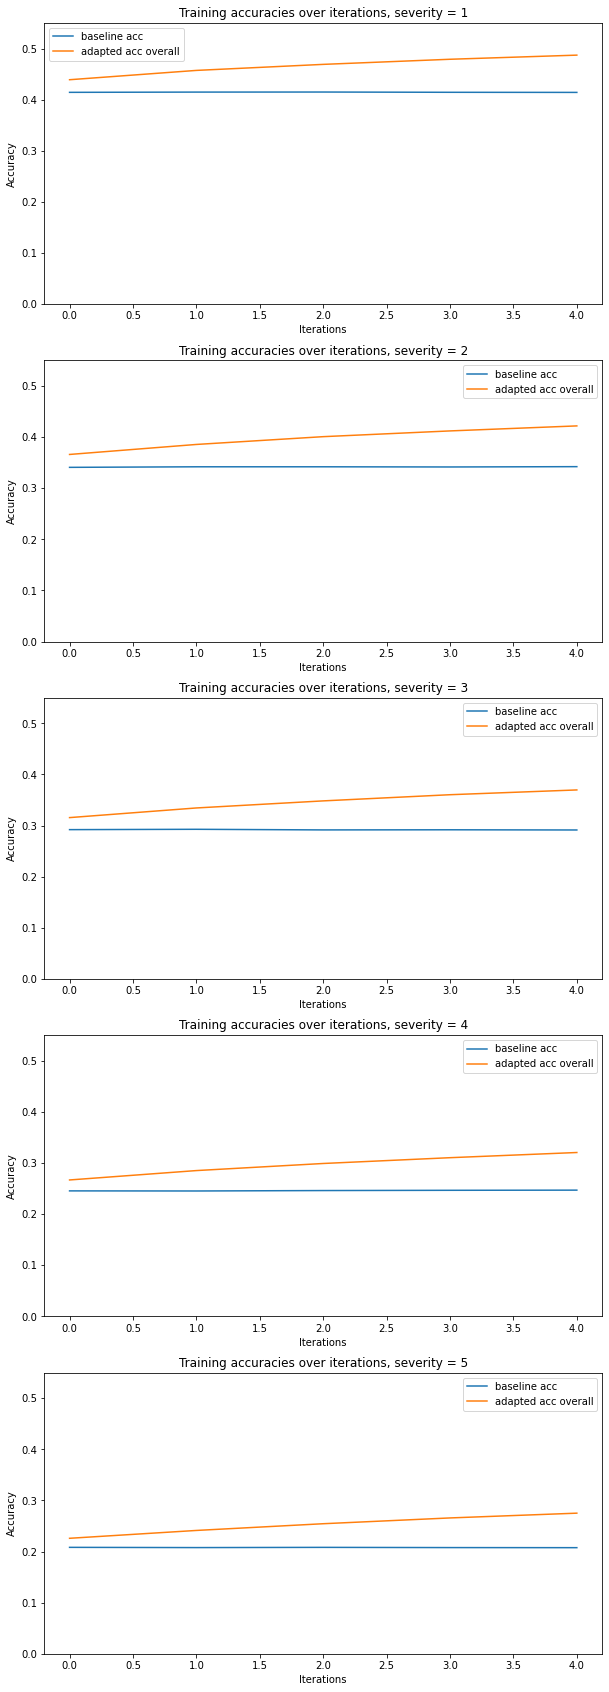

In [15]:
fig, ax = plt.subplots(5, figsize = [10,30])

subplot_ind = 0

for key, (base_acc, base_acc_epoch, adapted_train_acc_overall, adapted_train_acc_per_epoch, adapted_train_acc_per_iter, \
          _, _, _) in acc_record_sev.items():

    ax[subplot_ind].plot(base_acc, label='baseline acc')
    ax[subplot_ind].plot(adapted_train_acc_overall, label='adapted acc overall')
#     ax[subplot_ind].plot(adapted_online_acc_per_batch, label='adapted acc per batch')
    ax[subplot_ind].legend()
    ax[subplot_ind].set_title('Training accuracies over iterations, severity = ' + str(key))
    ax[subplot_ind].set_ylim([0, 0.55])
    ax[subplot_ind].set(xlabel="Iterations", ylabel="Accuracy")
    
    subplot_ind += 1

plt.show()

In [16]:
baseline_err = 0
for i in range (1,6):
    baseline_err += (1-acc_record_sev[i][0][-1])
baseline_err/5

tensor(0.6995)

In [19]:
adapted_err = 0
for i in range (1,6):
    adapted_err += (1-acc_record_sev[i][3][-1])
adapted_err/5

tensor(0.5877)

In [12]:
## Saving the recorded performances
import pickle

with open('orig_method_replicate.pkl', 'wb') as f:
    pickle.dump(acc_record_sev, f)
        
with open('orig_method_replicate.pkl', 'rb') as f:
    acc_record_sev = pickle.load(f)

Running experiment for batch_size = 32
Epoch 0
Baseline Correct:  142./ 512. (27.73 %)
Adapted Correct:  143./ 512. (27.93 %)
Epoch 1
Baseline Correct:  287./1024. (28.03 %)
Adapted Correct:  289./1024. (28.22 %)
Epoch 2
Baseline Correct:  438./1536. (28.52 %)
Adapted Correct:  443./1536. (28.84 %)
Epoch 3
Baseline Correct:  575./2048. (28.08 %)
Adapted Correct:  583./2048. (28.47 %)
Epoch 4
Baseline Correct:  724./2560. (28.28 %)
Adapted Correct:  736./2560. (28.75 %)
Running experiment for batch_size = 64
Epoch 0
Baseline Correct:  156./ 512. (30.47 %)
Adapted Correct:  156./ 512. (30.47 %)
Epoch 1
Baseline Correct:  305./1024. (29.79 %)
Adapted Correct:  305./1024. (29.79 %)
Epoch 2
Baseline Correct:  462./1536. (30.08 %)
Adapted Correct:  463./1536. (30.14 %)
Epoch 3
Baseline Correct:  626./2048. (30.57 %)
Adapted Correct:  631./2048. (30.81 %)
Epoch 4
Baseline Correct:  771./2560. (30.12 %)
Adapted Correct:  779./2560. (30.43 %)
Running experiment for batch_size = 96
Epoch 0
Basel

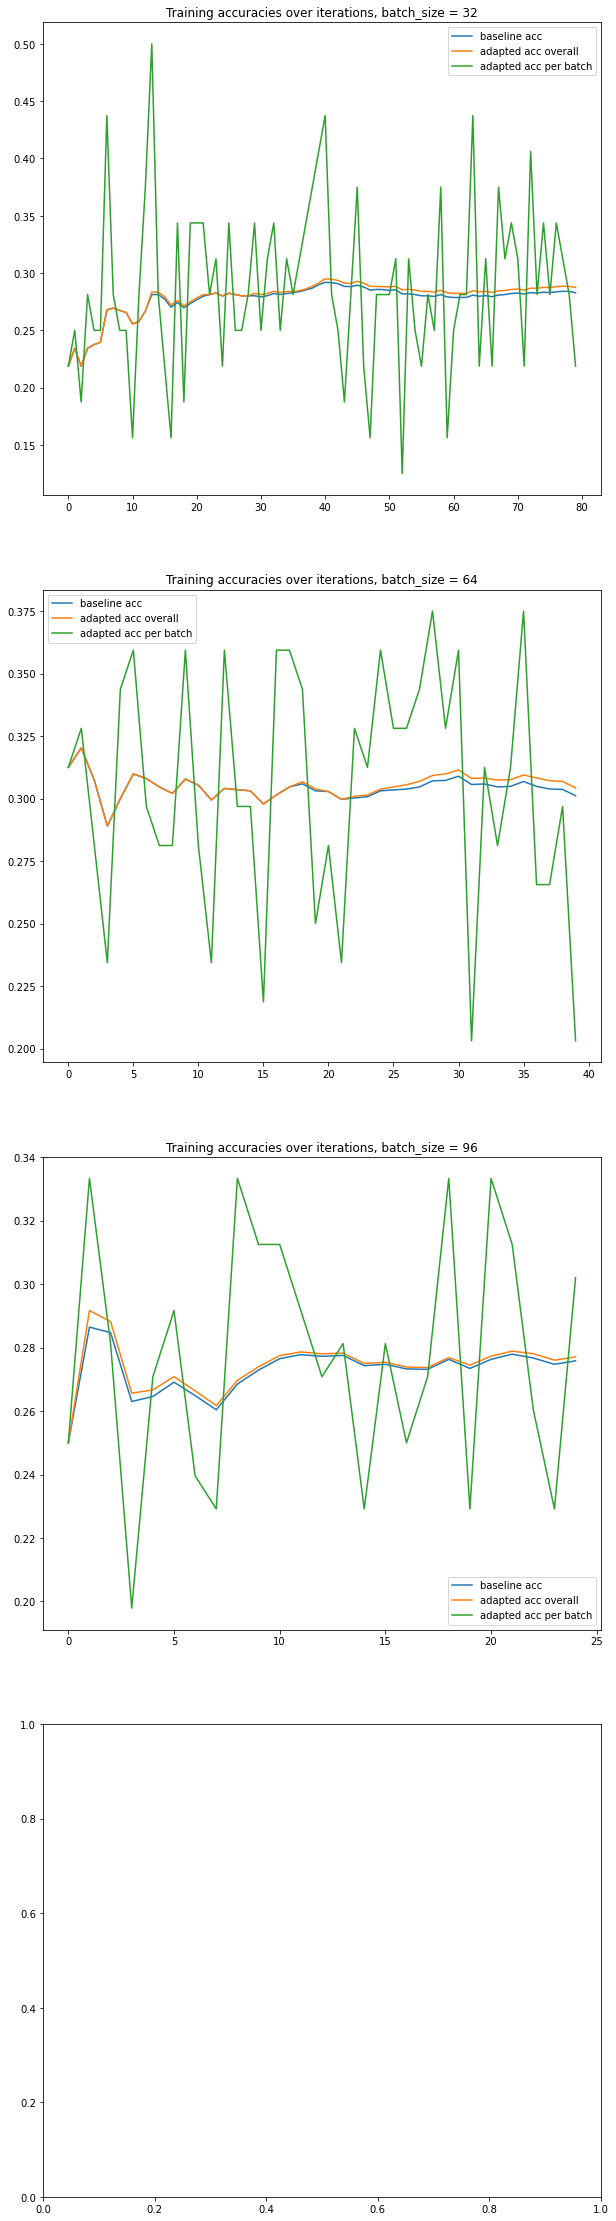

In [11]:
fig, ax = plt.subplots(4, figsize = [10,40])
subplot_ind = 0
acc_record = {}
for batch_size in [32, 64, 96]:
    
    print("Running experiment for batch_size =", batch_size)
    
    ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption \
    = get_imagenetc(imagebase, 3, batch_size, 512)

    base_acc, adapted_online_acc_overall, adapted_online_acc_per_batch = evaluate(corrupted_dataloaders[0]['train'], num_epochs=5)
    acc_record[batch_size] = base_acc, adapted_online_acc_overall, adapted_online_acc_per_batch

#     plt.rcParams["figure.figsize"] = (20,20)

    ax[subplot_ind].plot(base_acc, label='baseline acc')
    ax[subplot_ind].plot(adapted_online_acc_overall, label='adapted acc overall')
    ax[subplot_ind].plot(adapted_online_acc_per_batch, label='adapted acc per batch')
    ax[subplot_ind].legend()
    ax[subplot_ind].set_title('Training accuracies over iterations, batch_size = ' + str(batch_size))
    
    subplot_ind += 1

plt.show()

In [19]:
acc_record = {}
for batch_size in [96]:
    
    print("Running experiment for batch_size =", batch_size)
    
    ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption \
    = get_imagenetc(imagebase, 3, batch_size, 512)

    base_acc, adapted_online_acc_overall, adapted_online_acc_per_batch = evaluate(corrupted_dataloaders[0]['train'], num_epochs=50)
    acc_record[batch_size] = base_acc, adapted_online_acc_overall, adapted_online_acc_per_batch

Running experiment for batch_size = 96
Epoch 0
Baseline Correct:  147./ 480. (30.62 %)
Adapted Correct:  148./ 480. (30.83 %)
Epoch 1
Baseline Correct:  304./ 960. (31.67 %)
Adapted Correct:  306./ 960. (31.88 %)
Epoch 2
Baseline Correct:  457./1440. (31.74 %)
Adapted Correct:  459./1440. (31.88 %)
Epoch 3
Baseline Correct:  598./1920. (31.15 %)
Adapted Correct:  601./1920. (31.30 %)
Epoch 4
Baseline Correct:  736./2400. (30.67 %)
Adapted Correct:  740./2400. (30.83 %)
Epoch 5
Baseline Correct:  893./2880. (31.01 %)
Adapted Correct:  898./2880. (31.18 %)
Epoch 6
Baseline Correct: 1023./3360. (30.45 %)
Adapted Correct: 1030./3360. (30.65 %)
Epoch 7
Baseline Correct: 1173./3840. (30.55 %)
Adapted Correct: 1183./3840. (30.81 %)
Epoch 8
Baseline Correct: 1323./4320. (30.62 %)
Adapted Correct: 1334./4320. (30.88 %)
Epoch 9
Baseline Correct: 1468./4800. (30.58 %)
Adapted Correct: 1480./4800. (30.83 %)
Epoch 10
Baseline Correct: 1622./5280. (30.72 %)
Adapted Correct: 1638./5280. (31.02 %)
Epo

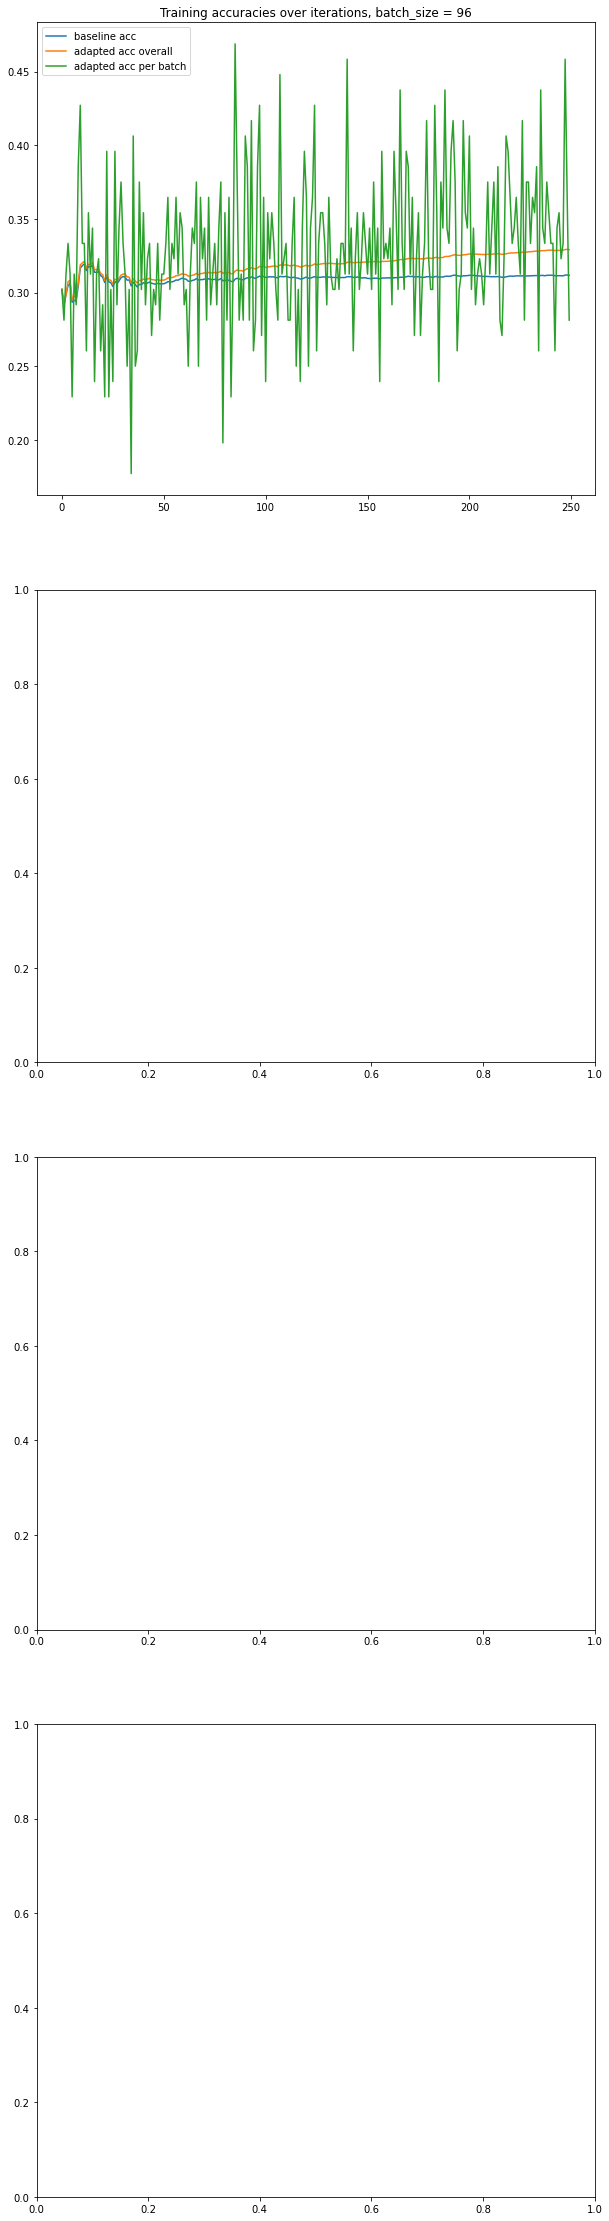

In [20]:
fig, ax = plt.subplots(4, figsize = [10,40])

subplot_ind = 0

for key, (base_acc, adapted_online_acc_overall, adapted_online_acc_per_batch) in acc_record.items():
    

    ax[subplot_ind].plot(base_acc, label='baseline acc')
    ax[subplot_ind].plot(adapted_online_acc_overall, label='adapted acc overall')
    ax[subplot_ind].plot(adapted_online_acc_per_batch, label='adapted acc per batch')
    ax[subplot_ind].legend()
    ax[subplot_ind].set_title('Training accuracies over iterations, batch_size = ' + str(batch_size))
    
    subplot_ind += 1

plt.show()

# TTA - Robust Pseudo label

In [17]:
import time

In [10]:
import torch
from torchvision import models, datasets, transforms

def gce(logits, target, q = 0.8):
    """ Generalized cross entropy.
    
    Reference: https://arxiv.org/abs/1805.07836
    """
    probs = torch.nn.functional.softmax(logits, dim=1)
    probs_with_correct_idx = probs.index_select(-1, target).diag()
    loss = (1. - probs_with_correct_idx**q) / q
    return loss.mean()

def adapt_batchnorm(model):
    model.eval()
    parameters = []
    for module in model.modules():
        if isinstance(module, torch.nn.BatchNorm2d):
            parameters.extend(module.parameters())
            module.train()
    return parameters


# ---



In [19]:
def adapt(
#         datadir = '/data/imagenetc/gaussian_blur/3',
        model,
        dataloader,
        num_epochs = 1, # followed their findings in the paper
        batch_size = 32,
        learning_rate = 0.75e-3,
        gce_q = 0.8,
    ):
    
#     model = models.resnet50(pretrained = True).to(device)
    parameters = adapt_batchnorm(model)
#     # TODO change this loader
#     val_loader = get_dataset_loader(
#         datadir,
#         batch_size = batch_size,
#         shuffle = True
#     )
    optimizer = torch.optim.SGD(
        model.parameters(), lr = learning_rate
    )
    print('DEBUGGING: model.parameters()',model.parameters())
    print('DEBUGGING: parameters',parameters)
    
    num_correct, num_samples = 0., 0.
    for epoch in range(num_epochs):
        predictions = []
#         batch_inf_times = []
        batch_accs = []
        for images, labels in dataloader:
#             start = time.time()
            
            outputs = model(images.to(device))
            predictions = outputs.argmax(dim = 1)
#             _, predicted = torch.max(outputs.data, 1)

#             inference_time = time.time() - start
#             batch_inf_times.append(inference_time)
           
#             batch_accuracy = ((predicted == labels).sum().item()) / labels.size(0)
#             batch_accs.append(batch_accuracy)
            
            # TODO: in our scenario, do we want to revert back to original model after adapting in each step?
            loss = gce(outputs, predictions, q = gce_q)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            num_correct += (predictions.detach().cpu() == labels).float().sum()
            num_samples += len(labels)
            print(f"Correct: {num_correct:#5.0f}/{num_samples:#5.0f} ({100 * num_correct / num_samples:.2f} %)")
            
    return model, (num_correct/num_samples)
            


In [20]:
target_sizes = [32, 64, 128, 256, 512, 1000]
severity = [1,2,3,4,5]

rpl_corrupt_train_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))
rpl_corrupt_val_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))
rpl_ref_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))


rpl_adpt_times = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))



In [21]:
for severity_ind in range(len(severity)):
    for ts_ind in range(len(target_sizes)):
        ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption \
        = get_imagenetc(imagebase, severity[severity_ind], 32, target_sizes[ts_ind])
        
        # TODO: wait, shouldn't I use a new model for every corruption?
        # uh bug!
        model = models.resnet50(pretrained=True)
        model.to(device)
        # adapt the model using the rpl methods
        # evaluate the adapted model on the test corrupted (target) dataset & the reference (source) dataset
        for cor_ind in range(len(corrupted_dataloaders)):
            
            print(f'## Experiment: Severity = {severity[severity_ind]}, target_size = {target_sizes[ts_ind]}, corruption = {corruption[cor_ind]}')

            # adapt the model
            start = time.time()
            model, train_acc = adapt(model, corrupted_dataloaders[cor_ind]['train'])
            adapt_time = time.time() - start
            print(f"Adaptation time: {adapt_time}")
            
            rpl_adpt_times[cor_ind, severity_ind, ts_ind] = adapt_time
            rpl_corrupt_train_acc[cor_ind, severity_ind, ts_ind] = train_acc
            
            # evaluate the adapted model on the, corrupted val data, and reference (soure) data
            with torch.no_grad():
                crpt_val_correct, crpt_val_samples, ref_correct, ref_samples = 0, 0, 0, 0
                for images, labels in corrupted_dataloaders[cor_ind]['val']:
                    labels = labels.to(device)
                    outputs = model(images.to(device))
                    _, predicted = torch.max(outputs.data, 1)
                    crpt_val_correct += (predicted == labels).sum().item()
                    crpt_val_samples += len(labels)
                print(f"Corrupt Val Accuracy: {crpt_val_correct:#5.0f}/{crpt_val_samples:#5.0f} ({crpt_val_correct / crpt_val_samples})")
                rpl_corrupt_val_acc[cor_ind, severity_ind, ts_ind] = crpt_val_correct / crpt_val_samples

                for images, labels in ref_dataloaders['val']:
                    labels = labels.to(device)
                    outputs = model(images.to(device))
                    _, predicted = torch.max(outputs.data, 1)
                    ref_correct += (predicted == labels).sum().item()
                    ref_samples += len(labels)
                print(f"Ref Accuracy: {ref_correct:#5.0f}/{ref_samples:#5.0f} ({ref_correct / ref_samples})")
                rpl_ref_acc[cor_ind, severity_ind, ts_ind] = ref_correct / ref_samples


#         with open('RPL_corrupt_train_acc.npy', 'wb') as f:
#             np.save(f, rpl_corrupt_train_acc)
#         with open('RPL_corrupt_validation_acc.npy', 'wb') as f:
#             np.save(f, rpl_corrupt_val_acc)
#         with open('RPL_target_acc.npy', 'wb') as f:
#             np.save(f, rpl_ref_acc)
#         with open('RPL_adapt_time.npy', 'wb') as f:
#             np.save(f, rpl_adpt_times)
        
        
            
            
            

## Experiment: Severity = 1, target_size = 32, corruption = zoom_blur
DEBUGGING: model.parameters() <generator object Module.parameters at 0x7f3a80187eb0>
DEBUGGING: parameters [Parameter containing:
tensor([2.3888e-01, 2.9136e-01, 3.1615e-01, 2.7122e-01, 2.1731e-01, 3.0903e-01,
        2.2937e-01, 2.3086e-01, 2.1129e-01, 2.8054e-01, 1.9923e-01, 3.1894e-01,
        1.7955e-01, 1.1246e-08, 1.9704e-01, 2.0996e-01, 2.4317e-01, 2.1697e-01,
        1.9415e-01, 3.1569e-01, 1.9648e-01, 2.3214e-01, 2.1962e-01, 2.1633e-01,
        2.4357e-01, 2.9683e-01, 2.3852e-01, 2.1162e-01, 1.4492e-01, 2.9388e-01,
        2.2911e-01, 9.2716e-02, 4.3334e-01, 2.0782e-01, 2.7990e-01, 3.5804e-01,
        2.9315e-01, 2.5306e-01, 2.4210e-01, 2.1755e-01, 3.8645e-01, 2.1003e-01,
        3.6805e-01, 3.3724e-01, 5.0826e-01, 1.9341e-01, 2.3914e-01, 2.6652e-01,
        3.9020e-01, 1.9840e-01, 2.1694e-01, 2.6666e-01, 4.9806e-01, 2.3553e-01,
        2.1349e-01, 2.5951e-01, 2.3547e-01, 1.7579e-01, 4.5354e-01, 1.7102e-01,


Correct:   17./  32. (53.12 %)
Adaptation time: 3.3626840114593506
Corrupt Val Accuracy:  606./ 992. (0.6108870967741935)
Ref Accuracy:  705./1000. (0.705)
## Experiment: Severity = 1, target_size = 32, corruption = speckle_noise
DEBUGGING: model.parameters() <generator object Module.parameters at 0x7f3a801b12e0>
DEBUGGING: parameters [Parameter containing:
tensor([2.3883e-01, 2.9134e-01, 3.1613e-01, 2.7140e-01, 2.1733e-01, 3.0912e-01,
        2.2932e-01, 2.3080e-01, 2.1125e-01, 2.8051e-01, 1.9923e-01, 3.1893e-01,
        1.7954e-01, 1.1246e-08, 1.9709e-01, 2.0993e-01, 2.4325e-01, 2.1707e-01,
        1.9414e-01, 3.1571e-01, 1.9642e-01, 2.3206e-01, 2.1955e-01, 2.1640e-01,
        2.4360e-01, 2.9681e-01, 2.3854e-01, 2.1169e-01, 1.4494e-01, 2.9383e-01,
        2.2917e-01, 9.2734e-02, 4.3341e-01, 2.0782e-01, 2.7989e-01, 3.5795e-01,
        2.9308e-01, 2.5320e-01, 2.4214e-01, 2.1747e-01, 3.8646e-01, 2.0998e-01,
        3.6803e-01, 3.3732e-01, 5.0823e-01, 1.9344e-01, 2.3915e-01, 2.6654e-01,


Correct:   16./  32. (50.00 %)
Adaptation time: 4.136745929718018
Corrupt Val Accuracy:  611./ 992. (0.6159274193548387)


KeyboardInterrupt: 

In [98]:
with open('RPL_corrupt_train_acc.npy', 'wb') as f:
    np.save(f, rpl_corrupt_train_acc)
with open('RPL_corrupt_validation_acc.npy', 'wb') as f:
    np.save(f, rpl_corrupt_val_acc)
with open('RPL_target_acc.npy', 'wb') as f:
    np.save(f, rpl_ref_acc)
with open('RPL_adapt_time.npy', 'wb') as f:
    np.save(f, rpl_adpt_times)


In [9]:
with open('RPL_corrupt_train_acc.npy', 'rb') as f:
    rpl_corrupt_train_acc = np.load(f)
with open('RPL_corrupt_validation_acc.npy', 'rb') as f:
    rpl_corrupt_val_acc = np.load(f)
with open('RPL_target_acc.npy', 'rb') as f:
    rpl_ref_acc = np.load(f)
with open('RPL_adapt_time.npy', 'rb') as f:
    rpl_adpt_times = np.load(f)


In [10]:
rpl_corrupt_val_acc

array([[[0.5796371 , 0.61995968, 0.60887097, 0.61391129, 0.59375   ,
         0.59879032],
        [0.55645161, 0.51814516, 0.51814516, 0.51512097, 0.5453629 ,
         0.54435484],
        [0.46270161, 0.49697581, 0.4828629 , 0.49092742, 0.46774194,
         0.50100806],
        [0.45362903, 0.4375    , 0.45262097, 0.42842742, 0.41532258,
         0.4233871 ],
        [0.39314516, 0.40120968, 0.39314516, 0.39012097, 0.38407258,
         0.39415323]],

       [[0.61995968, 0.65625   , 0.65221774, 0.64818548, 0.64616935,
         0.65020161],
        [0.58971774, 0.61592742, 0.58971774, 0.59879032, 0.58064516,
         0.60685484],
        [0.44657258, 0.44657258, 0.42741935, 0.45967742, 0.45665323,
         0.45060484],
        [0.39112903, 0.38407258, 0.40120968, 0.39919355, 0.36491935,
         0.38004032],
        [0.28225806, 0.25504032, 0.3125    , 0.2983871 , 0.29939516,
         0.30241935]],

       [[0.72983871, 0.69455645, 0.69657258, 0.72379032, 0.72580645,
         0.721774

In [104]:
rpl_corrupt_train_acc

array([[[0.1875    , 0.421875  , 0.3984375 , 0.41796875, 0.41601562,
         0.40927419],
        [0.3125    , 0.46875   , 0.3125    , 0.30078125, 0.34179688,
         0.34274194],
        [0.34375   , 0.28125   , 0.2734375 , 0.32421875, 0.27734375,
         0.29334676],
        [0.15625   , 0.15625   , 0.265625  , 0.265625  , 0.23242188,
         0.20967741],
        [0.28125   , 0.171875  , 0.1875    , 0.2109375 , 0.19335938,
         0.22177419]],

       [[0.53125   , 0.453125  , 0.4921875 , 0.4609375 , 0.50195312,
         0.50604838],
        [0.5625    , 0.4375    , 0.40625   , 0.3984375 , 0.50585938,
         0.4576613 ],
        [0.40625   , 0.3125    , 0.2890625 , 0.23046875, 0.29882812,
         0.30846775],
        [0.15625   , 0.140625  , 0.1796875 , 0.18359375, 0.1953125 ,
         0.22681452],
        [0.15625   , 0.125     , 0.1953125 , 0.15234375, 0.18554688,
         0.15524194]],

       [[0.71875   , 0.640625  , 0.640625  , 0.66015625, 0.60742188,
         0.644153

## Comparison with TENT

In [19]:
# validation accuracy averaged over all corruptions and all batch sizes
# sev1, 2, 3, 4, 5
rpl_corrupt_val_acc.transpose(2, 1, 0).mean(axis=0).mean(axis=1)

array([0.67395413, 0.59870632, 0.53384367, 0.45141339, 0.35242356])

In [20]:
# validation accuracy (batch size = 32) averaged over all corruptions
# sev1, 2, 3, 4, 5
rpl_corrupt_val_acc.transpose(2, 1, 0)[0].mean(axis=1)

array([0.67149698, 0.59450605, 0.52948589, 0.44449345, 0.34923135])

In [64]:
# validation error rate averaged over all corruptions and all batch sizes, shuffled
# sev5, 4, 3, 2, 1
(1 - rpl_corrupt_val_acc.transpose(2, 1, 0).mean(axis=0).mean(axis=1))[::-1]

array([0.64757644, 0.54858661, 0.46615633, 0.40129368, 0.32604587])

In [65]:
# validation error rate (batch size = 32) averaged over all corruptions, shuffled
# sev5, 4, 3, 2, 1
1 - rpl_corrupt_val_acc.transpose(2, 1, 0)[0].mean(axis=1)[::-1]

array([0.65076865, 0.55550655, 0.47051411, 0.40549395, 0.32850302])

## Comparison with RPL Paper

In [30]:
print(corruption)
1-rpl_corrupt_val_acc.mean(axis=1).mean(axis=1)

['zoom_blur', 'speckle_noise', 'spatter', 'snow', 'glass_blur', 'motion_blur', 'saturate', 'gaussian_blur', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 'defocus_blur']


array([0.51061828, 0.52624328, 0.43222446, 0.55090726, 0.62846102,
       0.52211022, 0.32402554, 0.58397177, 0.54868952, 0.40268817,
       0.30131048, 0.47086694, 0.42217742, 0.3905914 , 0.41875   ,
       0.61327285])

In [32]:
1 - baseline_performances.mean(axis=1).mean(axis=1)

array([0.63765941, 0.63858019, 0.50879715, 0.67556213, 0.73131435,
       0.61035379, 0.38323564, 0.58333158, 0.6227243 , 0.54395559,
       0.31226967, 0.61064041, 0.55121667, 0.55014742, 0.46622676,
       0.61470044])

# One-shot adaptation

In [9]:
import time

In [10]:
def few_shot_adapt(
#         datadir = '/data/imagenetc/gaussian_blur/3',
        model,
        dataloader,
        num_epochs = 1, # followed their findings in the paper
        batch_size = 32,
        learning_rate = 0.75e-3,
        gce_q = 0.8,
    ):
    
#     model = models.resnet50(pretrained = True).to(device)
    parameters = adapt_batchnorm(model)
#     # TODO change this loader
#     val_loader = get_dataset_loader(
#         datadir,
#         batch_size = batch_size,
#         shuffle = True
#     )
    optimizer = torch.optim.SGD(
        model.parameters(), lr = learning_rate
    )
    
    num_correct, num_samples = 0., 0.
    for epoch in range(num_epochs):
        predictions = []
#         batch_inf_times = []
        batch_accs = []
#         step = 0
        for images, labels in dataloader:
#             start = time.time()
#             print(f"DEBUGGING: num_samples = {num_samples}")
            outputs = model(images.to(device))
            predictions = outputs.argmax(dim = 1)
#             _, predicted = torch.max(outputs.data, 1)

#             inference_time = time.time() - start
#             batch_inf_times.append(inference_time)

#             batch_accuracy = ((predicted == labels).sum().item()) / labels.size(0)
#             batch_accs.append(batch_accuracy)

            # TODO: in our scenario, do we want to revert back to original model after adapting in each step?
            loss = gce(outputs, predictions, q = gce_q)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            outputs = model(images.to(device))
            predictions = outputs.argmax(dim = 1)

            num_correct += (predictions.detach().cpu() == labels).float().sum()
            num_samples += len(labels)
#                 print(f"DEBUGGING: len(labels) = {len(labels)}")

#                 step += 1
#                 print(f"Correct: {num_correct:#5.0f}/{num_samples:#5.0f} ({100 * num_correct / num_samples:.2f} %)")
    
    print(f"Correct: {num_correct:#5.0f}/{num_samples:#5.0f} ({100 * num_correct / num_samples:.2f} %)")
    return num_correct/num_samples
            


In [34]:
target_sizes = [32, 64, 128, 256, 512, 1000]
severity = [1,2,3,4,5]

rpl_one_shot_acc = np.zeros(shape=(len(corruption), len(severity)))
# rpl_corrupt_val_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))
# rpl_ref_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))


# rpl_one_shot_adpt_times = np.zeros(shape=(len(corruption), len(severity)))
device


device(type='cuda')

In [35]:
# test on 1000 datapoints within
for severity_ind in range(len(severity)):
    ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption \
    = get_imagenetc(imagebase, severity[severity_ind], 1, 1000)


    # adapt the model using the rpl methods
    # evaluate the adapted model on the test corrupted (target) dataset & the reference (source) dataset
    for cor_ind in range(len(corrupted_dataloaders)):
        print(f'## Experiment: Severity = {severity[severity_ind]}, corruption = {corruption[cor_ind]}, shot_size = {1}')
#         one_shot_accs = []
        
        model = models.resnet50(pretrained=True)
        model.to(device)


            # adapt the model
    #         start = time.time()
        training_acc = few_shot_adapt(model, corrupted_dataloaders[cor_ind]['train'])
    #         adapt_time = time.time() - start
    #         print(f"Adaptation time: {adapt_time}")
        print('Few_shot_accuracies are:', training_acc)

#         rpl_one_shot_adpt_times[cor_ind, severity_ind] = one_shot_accs.mean()
        rpl_one_shot_acc[cor_ind, severity_ind] = training_acc


    with open('rpl_one_shot_acc.npy', 'wb') as f:
        np.save(f, rpl_one_shot_acc)
#         with open('RPL_corrupt_validation_acc.npy', 'wb') as f:
#             np.save(f, rpl_corrupt_val_acc)
#         with open('RPL_target_acc.npy', 'wb') as f:
#             np.save(f, rpl_ref_acc)
#     with open('rpl_one_shot_adpt_times.npy', 'wb') as f:
#         np.save(f, rpl_one_shot_adpt_times)






## Experiment: Severity = 1, corruption = zoom_blur
Correct:    0./1000. (0.00 %)
One_shot_accuracies are: tensor(0.)
## Experiment: Severity = 1, corruption = speckle_noise
Correct:    0./1000. (0.00 %)
One_shot_accuracies are: tensor(0.)
## Experiment: Severity = 1, corruption = spatter
Correct:    2./1000. (0.20 %)
One_shot_accuracies are: tensor(0.0020)
## Experiment: Severity = 1, corruption = snow
Correct:    2./1000. (0.20 %)
One_shot_accuracies are: tensor(0.0020)
## Experiment: Severity = 1, corruption = glass_blur
Correct:    0./1000. (0.00 %)
One_shot_accuracies are: tensor(0.)
## Experiment: Severity = 1, corruption = motion_blur
Correct:    0./1000. (0.00 %)
One_shot_accuracies are: tensor(0.)
## Experiment: Severity = 1, corruption = saturate
Correct:    2./1000. (0.20 %)
One_shot_accuracies are: tensor(0.0020)
## Experiment: Severity = 1, corruption = gaussian_blur
Correct:    0./1000. (0.00 %)
One_shot_accuracies are: tensor(0.)
## Experiment: Severity = 1, corruption =

Correct:    3./1000. (0.30 %)
One_shot_accuracies are: tensor(0.0030)
## Experiment: Severity = 5, corruption = motion_blur
Correct:    0./1000. (0.00 %)
One_shot_accuracies are: tensor(0.)
## Experiment: Severity = 5, corruption = saturate
Correct:    1./1000. (0.10 %)
One_shot_accuracies are: tensor(0.0010)
## Experiment: Severity = 5, corruption = gaussian_blur
Correct:    1./1000. (0.10 %)
One_shot_accuracies are: tensor(0.0010)
## Experiment: Severity = 5, corruption = frost
Correct:    1./1000. (0.10 %)
One_shot_accuracies are: tensor(0.0010)
## Experiment: Severity = 5, corruption = fog
Correct:    0./1000. (0.00 %)
One_shot_accuracies are: tensor(0.)
## Experiment: Severity = 5, corruption = brightness
Correct:    1./1000. (0.10 %)
One_shot_accuracies are: tensor(0.0010)
## Experiment: Severity = 5, corruption = contrast
Correct:    2./1000. (0.20 %)
One_shot_accuracies are: tensor(0.0020)
## Experiment: Severity = 5, corruption = elastic_transform
Correct:    3./1000. (0.30 %)

In [36]:
rpl_one_shot_acc

array([[0.   , 0.002, 0.002, 0.002, 0.   ],
       [0.   , 0.   , 0.001, 0.001, 0.001],
       [0.002, 0.   , 0.001, 0.   , 0.001],
       [0.002, 0.002, 0.   , 0.002, 0.   ],
       [0.   , 0.003, 0.   , 0.001, 0.003],
       [0.   , 0.   , 0.002, 0.002, 0.   ],
       [0.002, 0.001, 0.002, 0.   , 0.001],
       [0.   , 0.001, 0.   , 0.   , 0.001],
       [0.   , 0.002, 0.   , 0.   , 0.001],
       [0.001, 0.001, 0.001, 0.001, 0.   ],
       [0.   , 0.001, 0.   , 0.002, 0.001],
       [0.   , 0.   , 0.002, 0.   , 0.002],
       [0.   , 0.   , 0.   , 0.   , 0.003],
       [0.   , 0.003, 0.   , 0.   , 0.002],
       [0.001, 0.   , 0.001, 0.   , 0.002],
       [0.   , 0.   , 0.   , 0.001, 0.   ]])

In [ ]:
# repeat same step 32 times outside
for severity_ind in range(len(severity)):
    ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption \
    = get_imagenetc(imagebase, severity[severity_ind], 1, 1)


    # adapt the model using the rpl methods
    # evaluate the adapted model on the test corrupted (target) dataset & the reference (source) dataset
    for cor_ind in range(len(corrupted_dataloaders)):
        print(f'## Experiment: Severity = {severity[severity_ind]}, corruption = {corruption[cor_ind]}')
        one_shot_accs = []
        
        for i in range(32):
            model = models.resnet50(pretrained=True)
            model.to(device)


            # adapt the model
    #         start = time.time()
            one_shot_accs.append(one_shot_adapt(model, corrupted_dataloaders[cor_ind]['train']))
    #         adapt_time = time.time() - start
    #         print(f"Adaptation time: {adapt_time}")
        print('One_shot_accuracies are:', one_shot_accs)

#         rpl_one_shot_adpt_times[cor_ind, severity_ind] = one_shot_accs.mean()
        rpl_one_shot_acc[cor_ind, severity_ind] = np.mean(one_shot_accs)


    with open('rpl_one_shot_acc.npy', 'wb') as f:
        np.save(f, rpl_one_shot_acc)
#         with open('RPL_corrupt_validation_acc.npy', 'wb') as f:
#             np.save(f, rpl_corrupt_val_acc)
#         with open('RPL_target_acc.npy', 'wb') as f:
#             np.save(f, rpl_ref_acc)
#     with open('rpl_one_shot_adpt_times.npy', 'wb') as f:
#         np.save(f, rpl_one_shot_adpt_times)






# Few-shot adaptation

In [26]:
import time

In [32]:
def few_shot_adapt(
#         datadir = '/data/imagenetc/gaussian_blur/3',
        model,
        dataloader,
        num_epochs = 1, # followed their findings in the paper
        batch_size = 32,
        learning_rate = 0.75e-3,
        gce_q = 0.8,
    ):
    
#     model = models.resnet50(pretrained = True).to(device)
    parameters = adapt_batchnorm(model)
#     # TODO change this loader
#     val_loader = get_dataset_loader(
#         datadir,
#         batch_size = batch_size,
#         shuffle = True
#     )
    optimizer = torch.optim.SGD(
        model.parameters(), lr = learning_rate
    )
    
    num_correct, num_samples = 0., 0.
    for epoch in range(num_epochs):
        predictions = []
#         batch_inf_times = []
        batch_accs = []
#         step = 0
        for images, labels in dataloader:
#             start = time.time()
#             print(f"DEBUGGING: num_samples = {num_samples}")
            outputs = model(images.to(device))
            predictions = outputs.argmax(dim = 1)
#             _, predicted = torch.max(outputs.data, 1)

#             inference_time = time.time() - start
#             batch_inf_times.append(inference_time)

#             batch_accuracy = ((predicted == labels).sum().item()) / labels.size(0)
#             batch_accs.append(batch_accuracy)

            # TODO: in our scenario, do we want to revert back to original model after adapting in each step?
            loss = gce(outputs, predictions, q = gce_q)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            outputs = model(images.to(device))
            predictions = outputs.argmax(dim = 1)

            num_correct += (predictions.detach().cpu() == labels).float().sum()
            num_samples += len(labels)
#                 print(f"DEBUGGING: len(labels) = {len(labels)}")

#                 step += 1
#                 print(f"Correct: {num_correct:#5.0f}/{num_samples:#5.0f} ({100 * num_correct / num_samples:.2f} %)")
    
    print(f"Correct: {num_correct:#5.0f}/{num_samples:#5.0f} ({100 * num_correct / num_samples:.2f} %)")
    return num_correct/num_samples
            


In [43]:
shot_sizes = [1, 5, 10, 15, 20, 25, 30, 32]
severity = [1,2,3,4,5]

rpl_few_shot_acc = np.zeros(shape=(len(corruption), len(severity), len(shot_sizes)))
# rpl_corrupt_val_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))
# rpl_ref_acc = np.zeros(shape=(len(corruption), len(severity), len(target_sizes)))


# rpl_one_shot_adpt_times = np.zeros(shape=(len(corruption), len(severity)))
device
rpl_few_shot_acc.shape

(16, 5, 8)

In [44]:
# test on 1000 datapoints within
for severity_ind in range(len(severity)):
    for ss_ind in range(len(shot_sizes)):
        ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption \
        = get_imagenetc(imagebase, severity[severity_ind], shot_sizes[ss_ind], 1000)


        # adapt the model using the rpl methods
        # evaluate the adapted model on the test corrupted (target) dataset & the reference (source) dataset
        for cor_ind in range(len(corrupted_dataloaders)):
            print(f'## Experiment: Severity = {severity[severity_ind]}, corruption = {corruption[cor_ind]}, shot_size = {shot_sizes[ss_ind]}')
    #         one_shot_accs = []

            model = models.resnet50(pretrained=True)
            model.to(device)


                # adapt the model
        #         start = time.time()
            training_acc = few_shot_adapt(model, corrupted_dataloaders[cor_ind]['train']).numpy()
        #         adapt_time = time.time() - start
        #         print(f"Adaptation time: {adapt_time}")
            print('One_shot_accuracies are:', training_acc)

    #         rpl_one_shot_adpt_times[cor_ind, severity_ind] = one_shot_accs.mean()
            rpl_few_shot_acc[cor_ind, severity_ind, ss_ind] = training_acc


        with open('rpl_few_shot_acc.npy', 'wb') as f:
            np.save(f, rpl_few_shot_acc)
    #         with open('RPL_corrupt_validation_acc.npy', 'wb') as f:
    #             np.save(f, rpl_corrupt_val_acc)
    #         with open('RPL_target_acc.npy', 'wb') as f:
    #             np.save(f, rpl_ref_acc)
    #     with open('rpl_one_shot_adpt_times.npy', 'wb') as f:
    #         np.save(f, rpl_one_shot_adpt_times)





## Experiment: Severity = 1, corruption = zoom_blur, shot_size = 1
Correct:    1./1000. (0.10 %)
One_shot_accuracies are: 0.001
## Experiment: Severity = 1, corruption = speckle_noise, shot_size = 1
Correct:    1./1000. (0.10 %)
One_shot_accuracies are: 0.001
## Experiment: Severity = 1, corruption = spatter, shot_size = 1
Correct:    1./1000. (0.10 %)
One_shot_accuracies are: 0.001
## Experiment: Severity = 1, corruption = snow, shot_size = 1
Correct:    1./1000. (0.10 %)
One_shot_accuracies are: 0.001
## Experiment: Severity = 1, corruption = glass_blur, shot_size = 1
Correct:    2./1000. (0.20 %)
One_shot_accuracies are: 0.002
## Experiment: Severity = 1, corruption = motion_blur, shot_size = 1
Correct:    2./1000. (0.20 %)
One_shot_accuracies are: 0.002
## Experiment: Severity = 1, corruption = saturate, shot_size = 1
Correct:    1./1000. (0.10 %)
One_shot_accuracies are: 0.001
## Experiment: Severity = 1, corruption = gaussian_blur, shot_size = 1
Correct:    1./1000. (0.10 %)
One_

Correct:  395./ 990. (39.90 %)
One_shot_accuracies are: 0.3989899
## Experiment: Severity = 1, corruption = zoom_blur, shot_size = 20
Correct:  390./1000. (39.00 %)
One_shot_accuracies are: 0.39
## Experiment: Severity = 1, corruption = speckle_noise, shot_size = 20
Correct:  486./1000. (48.60 %)
One_shot_accuracies are: 0.486
## Experiment: Severity = 1, corruption = spatter, shot_size = 20
Correct:  585./1000. (58.50 %)
One_shot_accuracies are: 0.585
## Experiment: Severity = 1, corruption = snow, shot_size = 20
Correct:  427./1000. (42.70 %)
One_shot_accuracies are: 0.427
## Experiment: Severity = 1, corruption = glass_blur, shot_size = 20
Correct:  404./1000. (40.40 %)
One_shot_accuracies are: 0.404
## Experiment: Severity = 1, corruption = motion_blur, shot_size = 20
Correct:  460./1000. (46.00 %)
One_shot_accuracies are: 0.46
## Experiment: Severity = 1, corruption = saturate, shot_size = 20
Correct:  558./1000. (55.80 %)
One_shot_accuracies are: 0.558
## Experiment: Severity = 1

Correct:  550./ 992. (55.44 %)
One_shot_accuracies are: 0.5544355
## Experiment: Severity = 1, corruption = jpeg_compression, shot_size = 32
Correct:  488./ 992. (49.19 %)
One_shot_accuracies are: 0.4919355
## Experiment: Severity = 1, corruption = defocus_blur, shot_size = 32
Correct:  372./ 992. (37.50 %)
One_shot_accuracies are: 0.375
## Experiment: Severity = 2, corruption = zoom_blur, shot_size = 1
Correct:    2./1000. (0.20 %)
One_shot_accuracies are: 0.002
## Experiment: Severity = 2, corruption = speckle_noise, shot_size = 1
Correct:    0./1000. (0.00 %)
One_shot_accuracies are: 0.0
## Experiment: Severity = 2, corruption = spatter, shot_size = 1
Correct:    0./1000. (0.00 %)
One_shot_accuracies are: 0.0
## Experiment: Severity = 2, corruption = snow, shot_size = 1
Correct:    2./1000. (0.20 %)
One_shot_accuracies are: 0.002
## Experiment: Severity = 2, corruption = glass_blur, shot_size = 1
Correct:    3./1000. (0.30 %)
One_shot_accuracies are: 0.003
## Experiment: Severity = 

Correct:  329./ 990. (33.23 %)
One_shot_accuracies are: 0.33232322
## Experiment: Severity = 2, corruption = pixelate, shot_size = 15
Correct:  525./ 990. (53.03 %)
One_shot_accuracies are: 0.530303
## Experiment: Severity = 2, corruption = jpeg_compression, shot_size = 15
Correct:  405./ 990. (40.91 %)
One_shot_accuracies are: 0.4090909
## Experiment: Severity = 2, corruption = defocus_blur, shot_size = 15
Correct:  263./ 990. (26.57 %)
One_shot_accuracies are: 0.26565656
## Experiment: Severity = 2, corruption = zoom_blur, shot_size = 20
Correct:  310./1000. (31.00 %)
One_shot_accuracies are: 0.31
## Experiment: Severity = 2, corruption = speckle_noise, shot_size = 20
Correct:  404./1000. (40.40 %)
One_shot_accuracies are: 0.404
## Experiment: Severity = 2, corruption = spatter, shot_size = 20
Correct:  480./1000. (48.00 %)
One_shot_accuracies are: 0.48
## Experiment: Severity = 2, corruption = snow, shot_size = 20
Correct:  248./1000. (24.80 %)
One_shot_accuracies are: 0.248
## Expe

Correct:  595./ 992. (59.98 %)
One_shot_accuracies are: 0.5997984
## Experiment: Severity = 2, corruption = contrast, shot_size = 32
Correct:  464./ 992. (46.77 %)
One_shot_accuracies are: 0.46774194
## Experiment: Severity = 2, corruption = elastic_transform, shot_size = 32
Correct:  375./ 992. (37.80 %)
One_shot_accuracies are: 0.3780242
## Experiment: Severity = 2, corruption = pixelate, shot_size = 32
Correct:  528./ 992. (53.23 %)
One_shot_accuracies are: 0.5322581
## Experiment: Severity = 2, corruption = jpeg_compression, shot_size = 32
Correct:  450./ 992. (45.36 %)
One_shot_accuracies are: 0.45362905
## Experiment: Severity = 2, corruption = defocus_blur, shot_size = 32
Correct:  309./ 992. (31.15 %)
One_shot_accuracies are: 0.31149194
## Experiment: Severity = 3, corruption = zoom_blur, shot_size = 1
Correct:    1./1000. (0.10 %)
One_shot_accuracies are: 0.001
## Experiment: Severity = 3, corruption = speckle_noise, shot_size = 1
Correct:    1./1000. (0.10 %)
One_shot_accurac

Correct:  366./ 990. (36.97 %)
One_shot_accuracies are: 0.36969697
## Experiment: Severity = 3, corruption = brightness, shot_size = 15
Correct:  532./ 990. (53.74 %)
One_shot_accuracies are: 0.5373737
## Experiment: Severity = 3, corruption = contrast, shot_size = 15
Correct:  313./ 990. (31.62 %)
One_shot_accuracies are: 0.3161616
## Experiment: Severity = 3, corruption = elastic_transform, shot_size = 15
Correct:  421./ 990. (42.53 %)
One_shot_accuracies are: 0.42525253
## Experiment: Severity = 3, corruption = pixelate, shot_size = 15
Correct:  431./ 990. (43.54 %)
One_shot_accuracies are: 0.43535355
## Experiment: Severity = 3, corruption = jpeg_compression, shot_size = 15
Correct:  390./ 990. (39.39 %)
One_shot_accuracies are: 0.3939394
## Experiment: Severity = 3, corruption = defocus_blur, shot_size = 15
Correct:  163./ 990. (16.46 %)
One_shot_accuracies are: 0.16464646
## Experiment: Severity = 3, corruption = zoom_blur, shot_size = 20
Correct:  283./1000. (28.30 %)
One_shot_a

Correct:  219./ 992. (22.08 %)
One_shot_accuracies are: 0.22076613
## Experiment: Severity = 3, corruption = frost, shot_size = 32
Correct:  226./ 992. (22.78 %)
One_shot_accuracies are: 0.22782259
## Experiment: Severity = 3, corruption = fog, shot_size = 32
Correct:  359./ 992. (36.19 %)
One_shot_accuracies are: 0.36189517
## Experiment: Severity = 3, corruption = brightness, shot_size = 32
Correct:  565./ 992. (56.96 %)
One_shot_accuracies are: 0.5695565
## Experiment: Severity = 3, corruption = contrast, shot_size = 32
Correct:  361./ 992. (36.39 %)
One_shot_accuracies are: 0.3639113
## Experiment: Severity = 3, corruption = elastic_transform, shot_size = 32
Correct:  471./ 992. (47.48 %)
One_shot_accuracies are: 0.47479838
## Experiment: Severity = 3, corruption = pixelate, shot_size = 32
Correct:  448./ 992. (45.16 %)
One_shot_accuracies are: 0.4516129
## Experiment: Severity = 3, corruption = jpeg_compression, shot_size = 32
Correct:  388./ 992. (39.11 %)
One_shot_accuracies are

Correct:  483./ 990. (48.79 %)
One_shot_accuracies are: 0.4878788
## Experiment: Severity = 4, corruption = gaussian_blur, shot_size = 15
Correct:  113./ 990. (11.41 %)
One_shot_accuracies are: 0.11414141
## Experiment: Severity = 4, corruption = frost, shot_size = 15
Correct:  213./ 990. (21.52 %)
One_shot_accuracies are: 0.21515152
## Experiment: Severity = 4, corruption = fog, shot_size = 15
Correct:  335./ 990. (33.84 %)
One_shot_accuracies are: 0.33838382
## Experiment: Severity = 4, corruption = brightness, shot_size = 15
Correct:  476./ 990. (48.08 %)
One_shot_accuracies are: 0.48080808
## Experiment: Severity = 4, corruption = contrast, shot_size = 15
Correct:  117./ 990. (11.82 %)
One_shot_accuracies are: 0.11818182
## Experiment: Severity = 4, corruption = elastic_transform, shot_size = 15
Correct:  421./ 990. (42.53 %)
One_shot_accuracies are: 0.42525253
## Experiment: Severity = 4, corruption = pixelate, shot_size = 15
Correct:  331./ 990. (33.43 %)
One_shot_accuracies are:

Correct:  111./ 992. (11.19 %)
One_shot_accuracies are: 0.11189516
## Experiment: Severity = 4, corruption = motion_blur, shot_size = 32
Correct:  143./ 992. (14.42 %)
One_shot_accuracies are: 0.14415322
## Experiment: Severity = 4, corruption = saturate, shot_size = 32
Correct:  494./ 992. (49.80 %)
One_shot_accuracies are: 0.49798387
## Experiment: Severity = 4, corruption = gaussian_blur, shot_size = 32
Correct:  155./ 992. (15.62 %)
One_shot_accuracies are: 0.15625
## Experiment: Severity = 4, corruption = frost, shot_size = 32
Correct:  223./ 992. (22.48 %)
One_shot_accuracies are: 0.22479838
## Experiment: Severity = 4, corruption = fog, shot_size = 32
Correct:  335./ 992. (33.77 %)
One_shot_accuracies are: 0.33770162
## Experiment: Severity = 4, corruption = brightness, shot_size = 32
Correct:  506./ 992. (51.01 %)
One_shot_accuracies are: 0.51008064
## Experiment: Severity = 4, corruption = contrast, shot_size = 32
Correct:  143./ 992. (14.42 %)
One_shot_accuracies are: 0.14415

Correct:  172./ 990. (17.37 %)
One_shot_accuracies are: 0.17373738
## Experiment: Severity = 5, corruption = glass_blur, shot_size = 15
Correct:   64./ 990. (6.46 %)
One_shot_accuracies are: 0.06464647
## Experiment: Severity = 5, corruption = motion_blur, shot_size = 15
Correct:  100./ 990. (10.10 %)
One_shot_accuracies are: 0.1010101
## Experiment: Severity = 5, corruption = saturate, shot_size = 15
Correct:  343./ 990. (34.65 %)
One_shot_accuracies are: 0.34646463
## Experiment: Severity = 5, corruption = gaussian_blur, shot_size = 15
Correct:   52./ 990. (5.25 %)
One_shot_accuracies are: 0.052525252
## Experiment: Severity = 5, corruption = frost, shot_size = 15
Correct:  149./ 990. (15.05 %)
One_shot_accuracies are: 0.15050505
## Experiment: Severity = 5, corruption = fog, shot_size = 15
Correct:  209./ 990. (21.11 %)
One_shot_accuracies are: 0.21111111
## Experiment: Severity = 5, corruption = brightness, shot_size = 15
Correct:  429./ 990. (43.33 %)
One_shot_accuracies are: 0.43

Correct:  150./ 992. (15.12 %)
One_shot_accuracies are: 0.15120968
## Experiment: Severity = 5, corruption = spatter, shot_size = 32
Correct:  241./ 992. (24.29 %)
One_shot_accuracies are: 0.24294356
## Experiment: Severity = 5, corruption = snow, shot_size = 32
Correct:  154./ 992. (15.52 %)
One_shot_accuracies are: 0.15524194
## Experiment: Severity = 5, corruption = glass_blur, shot_size = 32
Correct:   65./ 992. (6.55 %)
One_shot_accuracies are: 0.06552419
## Experiment: Severity = 5, corruption = motion_blur, shot_size = 32
Correct:  121./ 992. (12.20 %)
One_shot_accuracies are: 0.12197581
## Experiment: Severity = 5, corruption = saturate, shot_size = 32
Correct:  384./ 992. (38.71 %)
One_shot_accuracies are: 0.38709676
## Experiment: Severity = 5, corruption = gaussian_blur, shot_size = 32
Correct:   50./ 992. (5.04 %)
One_shot_accuracies are: 0.050403226
## Experiment: Severity = 5, corruption = frost, shot_size = 32
Correct:  168./ 992. (16.94 %)
One_shot_accuracies are: 0.169

In [72]:
with open('rpl_few_shot_acc.npy', 'rb') as f:
    rpl_few_shot_acc = np.load(f)

In [73]:
rpl_few_shot_acc

array([[[0.001     , 0.315     , 0.389     , 0.39292929, 0.38999999,
         0.36500001, 0.38989899, 0.37903225],
        [0.002     , 0.241     , 0.308     , 0.31212121, 0.31      ,
         0.33199999, 0.33737373, 0.33165324],
        [0.001     , 0.176     , 0.23      , 0.27878788, 0.28299999,
         0.27900001, 0.30505049, 0.28830644],
        [0.002     , 0.162     , 0.2       , 0.19797979, 0.233     ,
         0.23899999, 0.24040404, 0.21774194],
        [0.        , 0.132     , 0.198     , 0.17777778, 0.204     ,
         0.206     , 0.22424242, 0.19052419]],

       [[0.001     , 0.38800001, 0.44      , 0.47272727, 0.486     ,
         0.49599999, 0.50707072, 0.49899194],
        [0.        , 0.32800001, 0.391     , 0.43333334, 0.40400001,
         0.41299999, 0.44141415, 0.42137095],
        [0.001     , 0.212     , 0.25      , 0.26666668, 0.28999999,
         0.292     , 0.310101  , 0.28931451],
        [0.002     , 0.15800001, 0.20299999, 0.23232323, 0.208     ,
         

# Graphs

In [49]:
import matplotlib.pyplot as plt

In [10]:
# severity 5, 16 graphs for 16 corruptions, 
# 6 lines for 6 batch sizes, an extra line for baseline corruption, an extra line for ref

In [55]:
with open('ResNet50_performances.npy', 'rb') as f:
    baseline_performances = np.load(f)
with open('ResNet50_times.npy', 'rb') as f:
    baseline_inf_times = np.load(f)
with open('RPL_corrupt_train_acc.npy', 'rb') as f:
    rpl_corrupt_train_acc = np.load(f)
with open('RPL_corrupt_validation_acc.npy', 'rb') as f:
    rpl_corrupt_val_acc = np.load(f)
with open('RPL_target_acc.npy', 'rb') as f:
    rpl_ref_acc = np.load(f)
with open('RPL_adapt_time.npy', 'rb') as f:
    rpl_adpt_times = np.load(f)


In [57]:
target_sizes = [32, 64, 128, 256, 512, 1000]
severity = [1,2,3,4,5]
shot_sizes = [1, 5, 10, 15, 20, 25, 30, 32]

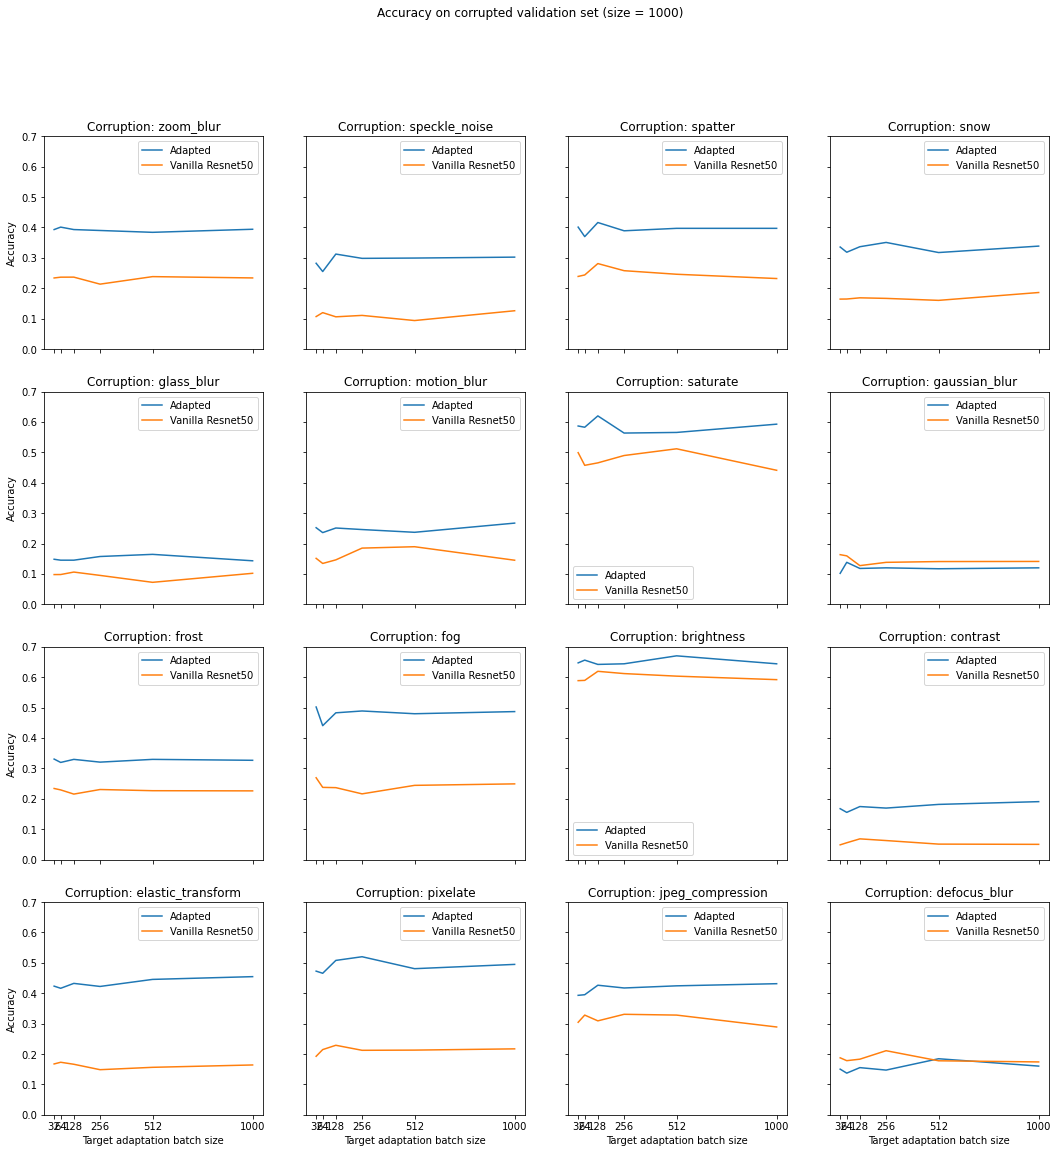

In [51]:
fig, ax = plt.subplots(4,4, figsize=(18, 18))
fig.suptitle('Accuracy on corrupted validation set (size = 1000)')
for cor_ind in range(len(corruption)):
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][0])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][1])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][2])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][3])
    ax[cor_ind//4][cor_ind%4].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][4], label='Adapted')
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_train_acc[cor_ind][4], label='corrupted training(adapting) accuracy')
#     ax[cor_ind].plot(target_sizes, rpl_ref_acc[cor_ind][4])
    ax[cor_ind//4][cor_ind%4].plot(target_sizes, baseline_performances[cor_ind][4], label = 'Vanilla Resnet50')
    ax[cor_ind//4][cor_ind%4].legend()
    ax[cor_ind//4][cor_ind%4].set_title('Corruption: '+corruption[cor_ind])
    ax[cor_ind//4][cor_ind%4].set_xticks(target_sizes)
    ax[cor_ind//4][cor_ind%4].set_ylim([0, 0.7])


    
for a in ax.flat:
    a.set(xlabel='Target adaptation batch size', ylabel='Accuracy')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

NameError: name 'target_sizes' is not defined

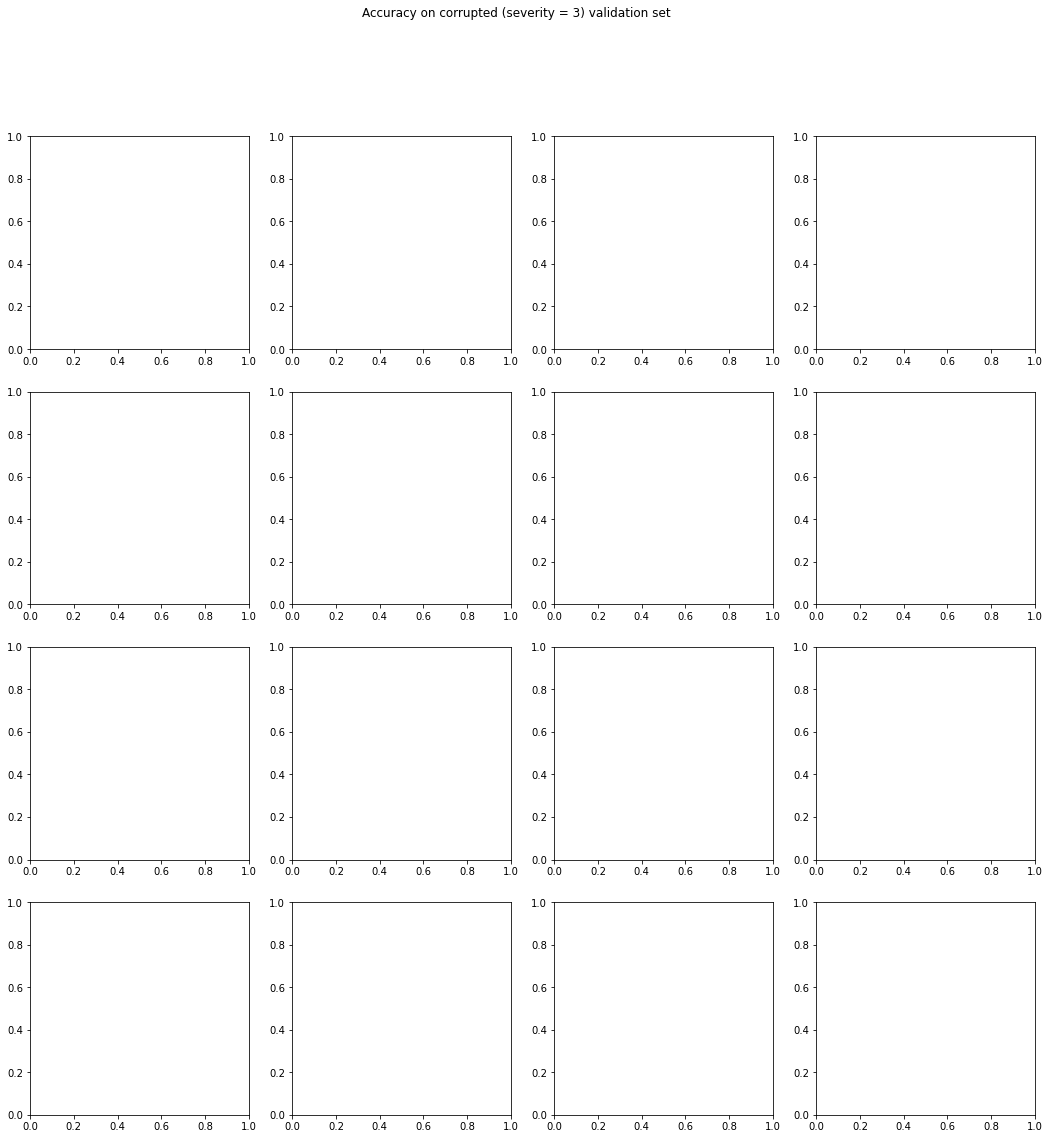

In [50]:
fig, ax = plt.subplots(4,4, figsize=(18, 18))
fig.suptitle('Accuracy on corrupted (severity = 3) validation set')
for cor_ind in range(len(corruption)):
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][0])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][1])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][2])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][3])
    ax[cor_ind//4][cor_ind%4].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][2], label='Adapted')
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_train_acc[cor_ind][4], label='corrupted training(adapting) accuracy')
#     ax[cor_ind].plot(target_sizes, rpl_ref_acc[cor_ind][4])
    ax[cor_ind//4][cor_ind%4].plot(target_sizes, baseline_performances[cor_ind][2], label = 'Vanilla Resnet50')
    ax[cor_ind//4][cor_ind%4].legend()
    ax[cor_ind//4][cor_ind%4].set_title('Corruption: '+corruption[cor_ind])
    ax[cor_ind//4][cor_ind%4].set_xticks(target_sizes)
    ax[cor_ind//4][cor_ind%4].set_ylim([0, 0.9])


    
for a in ax.flat:
    a.set(xlabel='Target adaptation batch size', ylabel='Accuracy')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

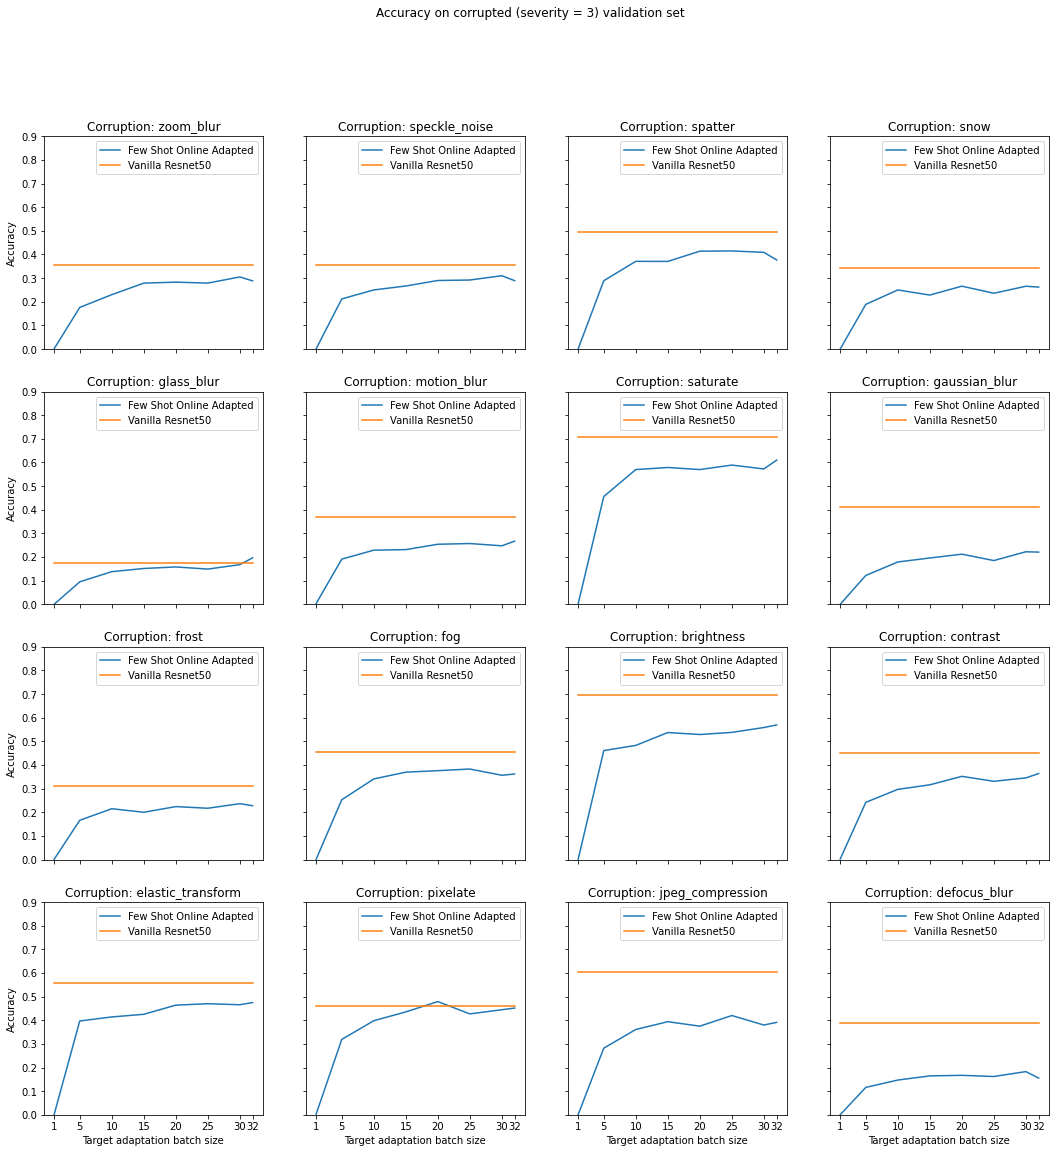

In [74]:
fig, ax = plt.subplots(4,4, figsize=(18, 18))
fig.suptitle('Accuracy on corrupted (severity = 3) validation set')
for cor_ind in range(len(corruption)):
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][0])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][1])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][2])
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_val_acc[cor_ind][3])
    ax[cor_ind//4][cor_ind%4].plot(shot_sizes, rpl_few_shot_acc[cor_ind][2], label='Few Shot Online Adapted')
#     ax[cor_ind].plot(target_sizes, rpl_corrupt_train_acc[cor_ind][4], label='corrupted training(adapting) accuracy')
#     ax[cor_ind].plot(target_sizes, rpl_ref_acc[cor_ind][4])
    ax[cor_ind//4][cor_ind%4].plot(shot_sizes, baseline_performances[cor_ind][2][0].repeat(8), label = 'Vanilla Resnet50')
    ax[cor_ind//4][cor_ind%4].legend()
    ax[cor_ind//4][cor_ind%4].set_title('Corruption: '+corruption[cor_ind])
    ax[cor_ind//4][cor_ind%4].set_xticks(shot_sizes)
    ax[cor_ind//4][cor_ind%4].set_ylim([0, 0.9])


    
for a in ax.flat:
    a.set(xlabel='Target adaptation batch size', ylabel='Accuracy')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

In [68]:
baseline_performances[1][2][0].repeat(8)

array([0.35483871, 0.35483871, 0.35483871, 0.35483871, 0.35483871,
       0.35483871, 0.35483871, 0.35483871])

In [25]:
ref_dataset_sizes

{'val': 1000, 'test': 1000}

In [26]:
len(ref_dataloaders['val'])


391

In [44]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model.eval()

Using cache found in /home/zw2774/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
zoom_blur_loader = corrupted_dataloaders[0]['train']

In [56]:
corrects = 0
for images, labels in zoom_blur_loader:
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    corrects += torch.sum(preds == labels.data)
total_accuracy = corrects/corrupted_dataset_sizes[0]['train']

In [55]:
torch.sum(preds == y.data)

tensor(15)